In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, roc_curve, confusion_matrix, classification_report, mean_squared_error, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [63]:
df = pd.read_csv('https://raw.githubusercontent.com/mn42899/data_scienceii/refs/heads/main/train.csv', delimiter = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [64]:
#Check Data ranges for the numerical columns 
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [66]:
# binary output
df['y'] = df['y'].map({'no': 0, 'yes': 1})

Data Distribution Observations

In [67]:
#Single people have highest chance of subscribing
df.groupby(['marital'], as_index=False)['y'].mean()

,marital,y
0,divorced,0.119455
1,married,0.101235
2,single,0.149492


In [68]:
#Higher chance of people without a mortgage subscribing to a term deposit
df.groupby(['housing'], as_index=False)['y'].mean()

,housing,y
0,no,0.167024
1,yes,0.077000


In [69]:
#People with loan see similar results
df.groupby(['loan'], as_index=False)['y'].mean()

,loan,y
0,no,0.126557
1,yes,0.066814


In [70]:
#Those who are retired or a student will have the highest chance of subscribing to a term deposit -- C
df.groupby(['job'], as_index=False)['y'].mean()

,job,y
0,admin.,0.122027
1,blue-collar,0.072750
2,entrepreneur,0.082717
3,housemaid,0.087903
4,management,0.137556
5,retired,0.227915
6,self-employed,0.118429
7,services,0.088830
8,student,0.286780
9,technician,0.110570


In [71]:
#When point of contact was used, led to higher chance of the user subscribing 
df.groupby(['contact'], as_index=False)['y'].mean()

,contact,y
0,cellular,0.149189
1,telephone,0.134205
2,unknown,0.040707


In [72]:
#People who got their undergrad or post grad have the highest chance of subscribing to a term deposit
df.groupby(['education'], as_index=False)['y'].mean()

,education,y
0,primary,0.086265
1,secondary,0.105594
2,tertiary,0.150064
3,unknown,0.135703


In [73]:
#Highest months were march, october, september, december
df.groupby(['month'], as_index=False)['y'].mean()

,month,y
0,apr,0.196794
1,aug,0.110133
2,dec,0.467290
3,feb,0.166478
4,jan,0.101212
5,jul,0.090935
6,jun,0.102228
7,mar,0.519916
8,may,0.067195
9,nov,0.101511


In [74]:
#First and the 9th of the month saw the highest percentage chance to subscribe
df.groupby(['day'], as_index=False)['y'].mean()

,day,y
0,1,0.279503
1,2,0.140758
2,3,0.164968
3,4,0.159170
4,5,0.112565
5,6,0.093685
6,7,0.086406
7,8,0.109121
8,9,0.114670
9,10,0.230916


In [75]:
df['age_cut'] = pd.qcut(df['age'], 6)

In [76]:
#Individuals aged 52+ and under 31 were most likely to subscribe to a term deposit
df.groupby(['age_cut'], as_index=False)['y'].mean()

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1534/1308152034.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['age_cut'], as_index=False)['y'].mean()


,age_cut,y
0,"(17.999, 31.0]",0.149679
1,"(31.0, 35.0]",0.106332
2,"(35.0, 39.0]",0.101007
3,"(39.0, 45.0]",0.087691
4,"(45.0, 52.0]",0.092045
5,"(52.0, 95.0]",0.155373


In [77]:
#Success of the marketing campaign only accounts for 65% of users that will subscribe
df.groupby(['poutcome'], as_index=False)['y'].mean()

,poutcome,y
0,failure,0.126097
1,other,0.166848
2,success,0.647253
3,unknown,0.091615


<Axes: xlabel='y', ylabel='Count'>

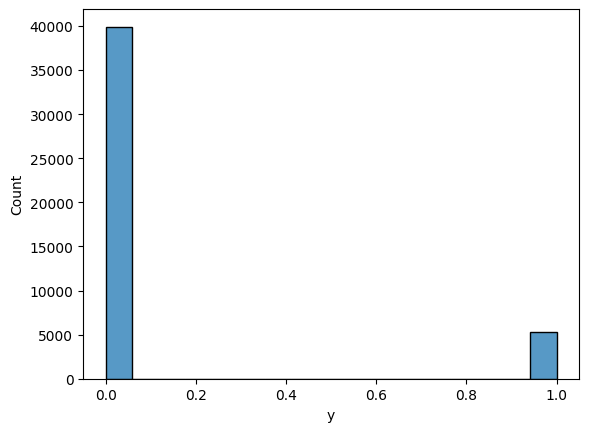

In [78]:
sns.histplot(x=df['y'])

<Axes: ylabel='age'>

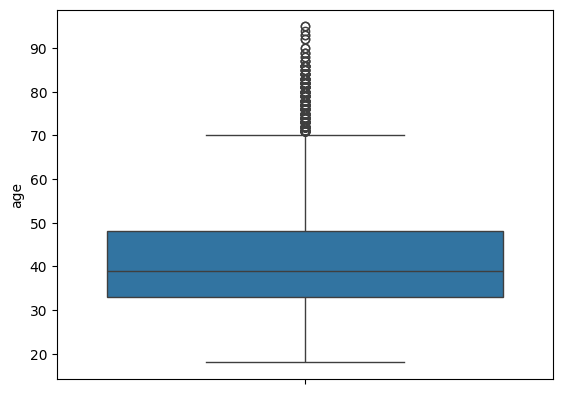

In [79]:
sns.boxplot(df['age'])

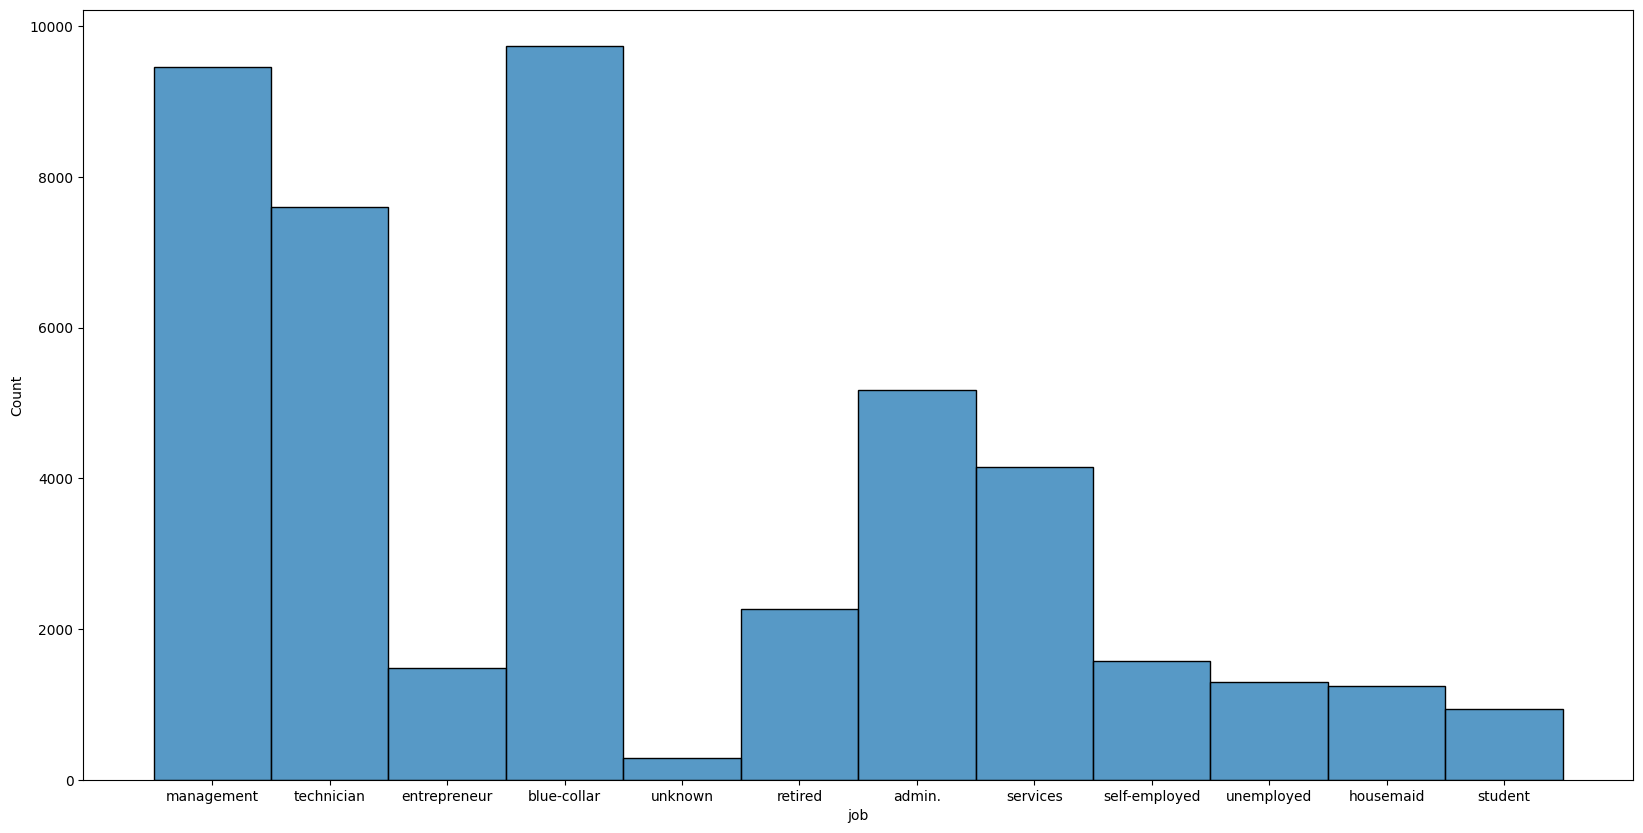

In [80]:
plt.figure(figsize=(20,10))
sns.histplot(x=df['job'])
plt.show()

<Axes: xlabel='marital', ylabel='Count'>

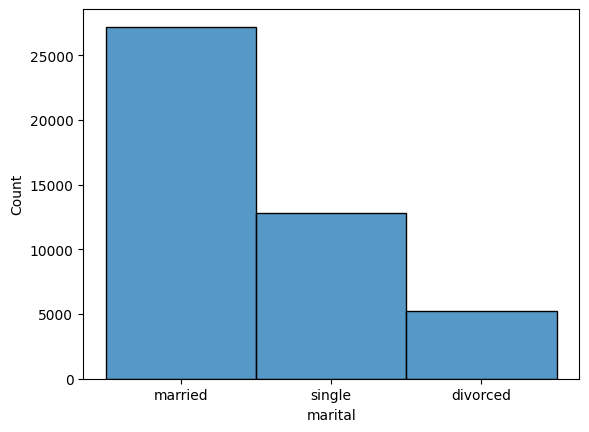

In [81]:
sns.histplot(x=df['marital'])

<Axes: xlabel='education', ylabel='Count'>

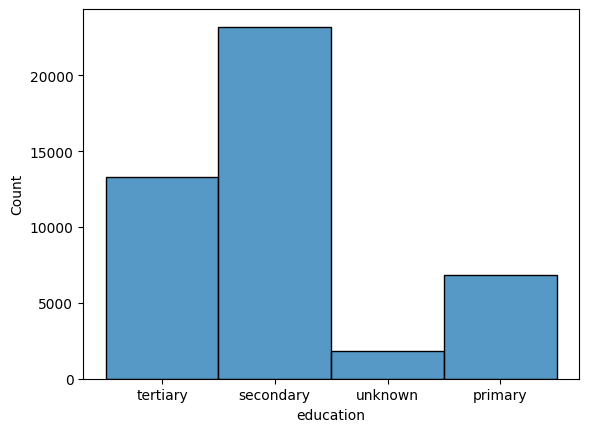

In [82]:
sns.histplot(x=df['education'])

In [83]:
df['education'].value_counts().reset_index()

,education,count
0,secondary,23202
1,tertiary,13301
2,primary,6851
3,unknown,1857


<Axes: xlabel='balance', ylabel='Count'>

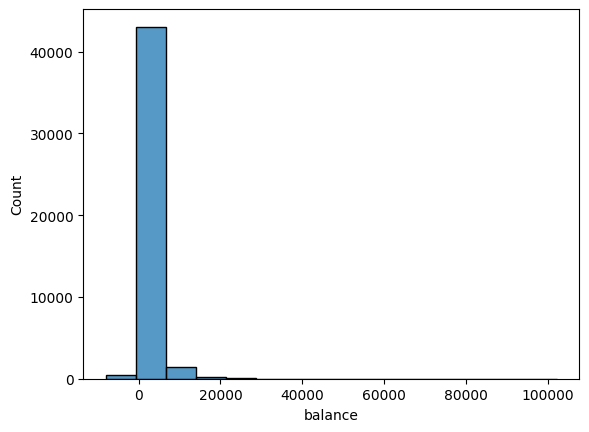

In [84]:
sns.histplot(x=df['balance'], bins=15)

In [85]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

<Axes: xlabel='housing', ylabel='Count'>

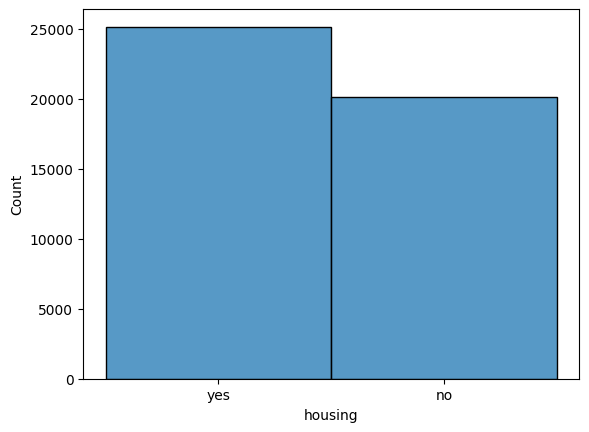

In [86]:
#Distribution for if they bought a mortgage or not

sns.histplot(df['housing'])

<Axes: xlabel='loan', ylabel='Count'>

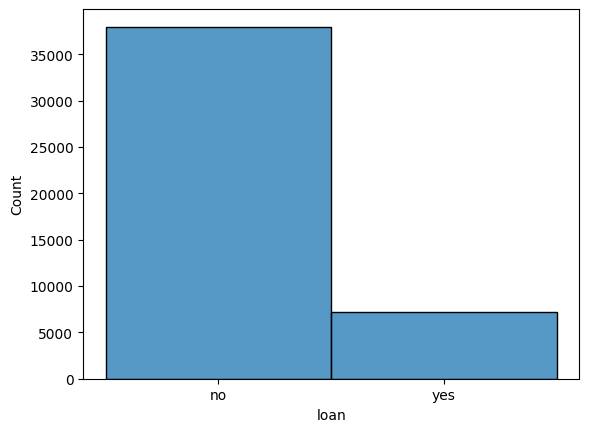

In [87]:
sns.histplot(df['loan'])

<Axes: xlabel='contact', ylabel='Count'>

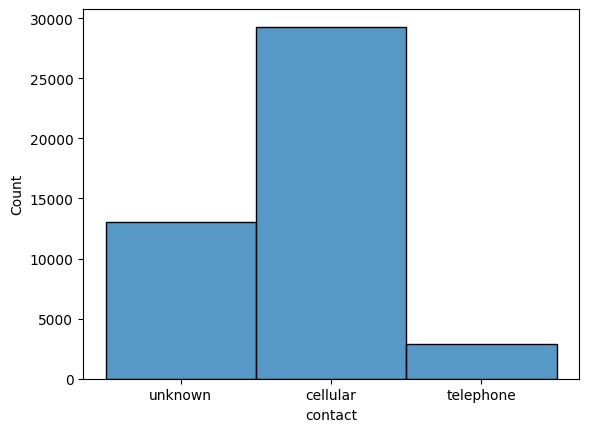

In [88]:
sns.histplot(df['contact'])

<Axes: xlabel='day', ylabel='Count'>

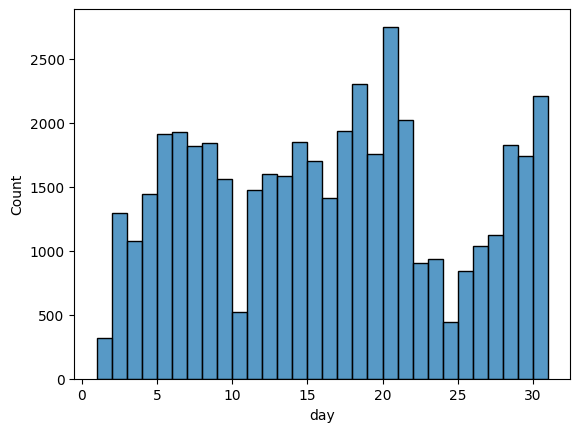

In [89]:
#majority of the distribution were contacted on the 21st of each month

sns.histplot(df['day'],bins=30)

<Axes: xlabel='month', ylabel='Count'>

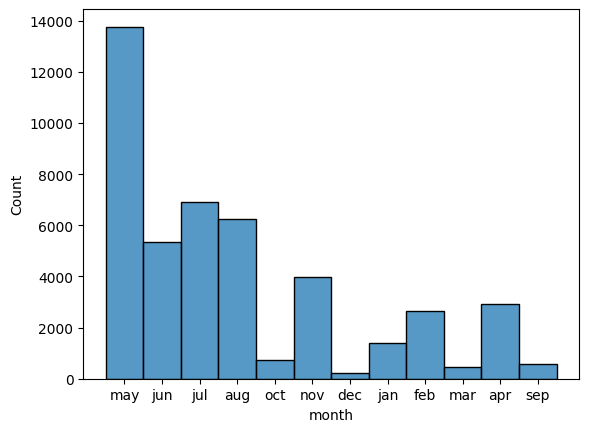

In [90]:
#Majority of the sample were contacted in May and began to fall off significantly throughout the distribution
sns.histplot(df['month'])

<Axes: xlabel='duration', ylabel='Count'>

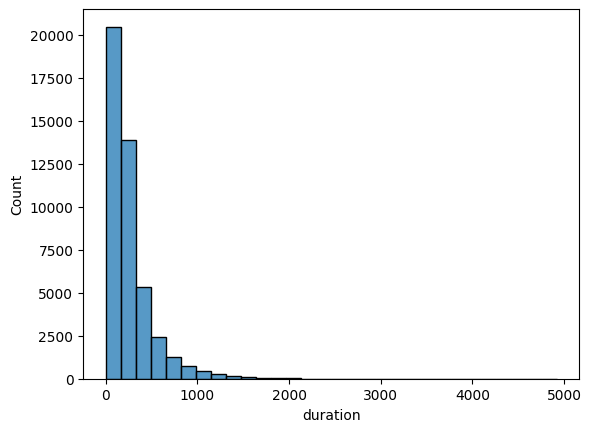

In [91]:
sns.histplot(df['duration'], bins=30)

In [92]:
df['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [93]:
df['duration']

0         261
1         151
2          76
3          92
4         198
         ... 
45206     977
45207     456
45208    1127
45209     508
45210     361
Name: duration, Length: 45211, dtype: int64

<Axes: xlabel='campaign', ylabel='Count'>

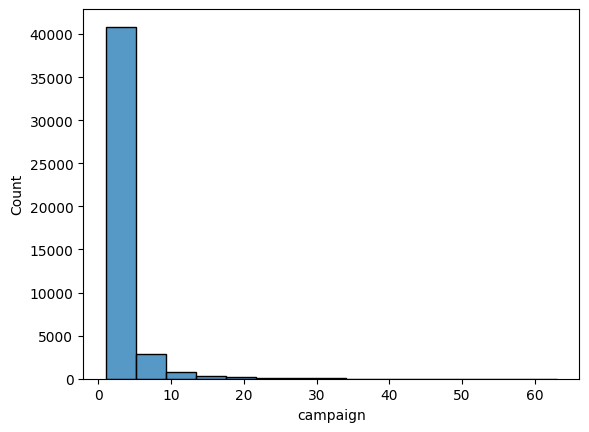

In [94]:
sns.histplot(x=df['campaign'], bins=15)

<Axes: xlabel='pdays', ylabel='Count'>

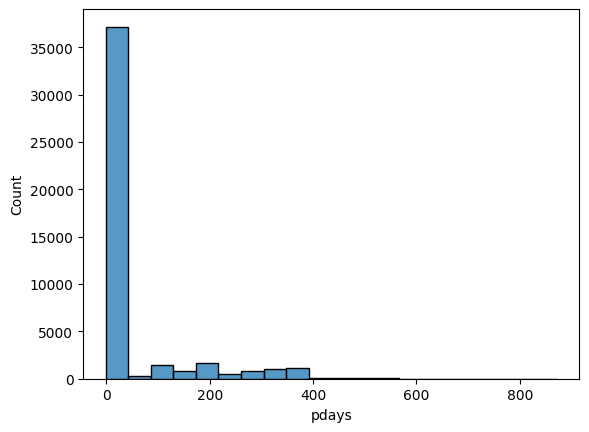

In [95]:
sns.histplot(df['pdays'], bins=20)

In [96]:
#Interesting variable for those who subscribed a term deposit - will look into this
df['pdays'].value_counts().reset_index()

,pdays,count
0,-1,36954
1,182,167
2,92,147
3,91,126
4,183,126
...,...,...
554,449,1
555,452,1
556,648,1
557,595,1


In [97]:
# Too many unknown observations, need to find an explanation how to interpret them. Success can be assumed to be those who
# subscribed a term deposit... "Other" category can be determined as a "maybe" for those responding from the campaign they were
# exposed to.
df['poutcome'].value_counts().reset_index()

,poutcome,count
0,unknown,36959
1,failure,4901
2,other,1840
3,success,1511


In [98]:
df['y'].value_counts().reset_index()

,y,count
0,0,39922
1,1,5289


In [99]:
#Converting to Date/Time Function

year = 2008

years = []

# Loop through each row of the DataFrame -- Understand how this works
for index, row in df.iterrows():
    # If the month is 'dec', assign the current year and then increment for the next rows
    if row['month'] == 'dec' and index > 0 and df.iloc[index - 1]['month'] != 'dec':
        years.append(year)
        year += 1
    else:
        years.append(year)

df['year'] = years

df['date'] = pd.to_datetime(df['day'].astype(str) + '-' + df['month'] + '-' + df['year'].astype(str), format='%d-%b-%Y') 
df


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,age_cut,year,date
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,"(52.0, 95.0]",2008,2008-05-05
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,"(39.0, 45.0]",2008,2008-05-05
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,"(31.0, 35.0]",2008,2008-05-05
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0,"(45.0, 52.0]",2008,2008-05-05
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0,"(31.0, 35.0]",2008,2008-05-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1,"(45.0, 52.0]",2010,2010-11-17
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1,"(52.0, 95.0]",2010,2010-11-17
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1,"(52.0, 95.0]",2010,2010-11-17
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0,"(52.0, 95.0]",2010,2010-11-17


In [100]:
# Assuming 'date' column exists and is in datetime format
# Find the maximum date (most recent contact)
max_date = df['date'].max()

# Calculate the difference between the max_date and each row in the 'date' column
df['last_contacted'] = (max_date - df['date']).dt.days
df['last_contacted']

0        970
1        970
2        970
3        970
4        970
        ... 
45206     44
45207     44
45208     44
45209     44
45210     44
Name: last_contacted, Length: 45211, dtype: int64

<Axes: xlabel='y', ylabel='pdays'>

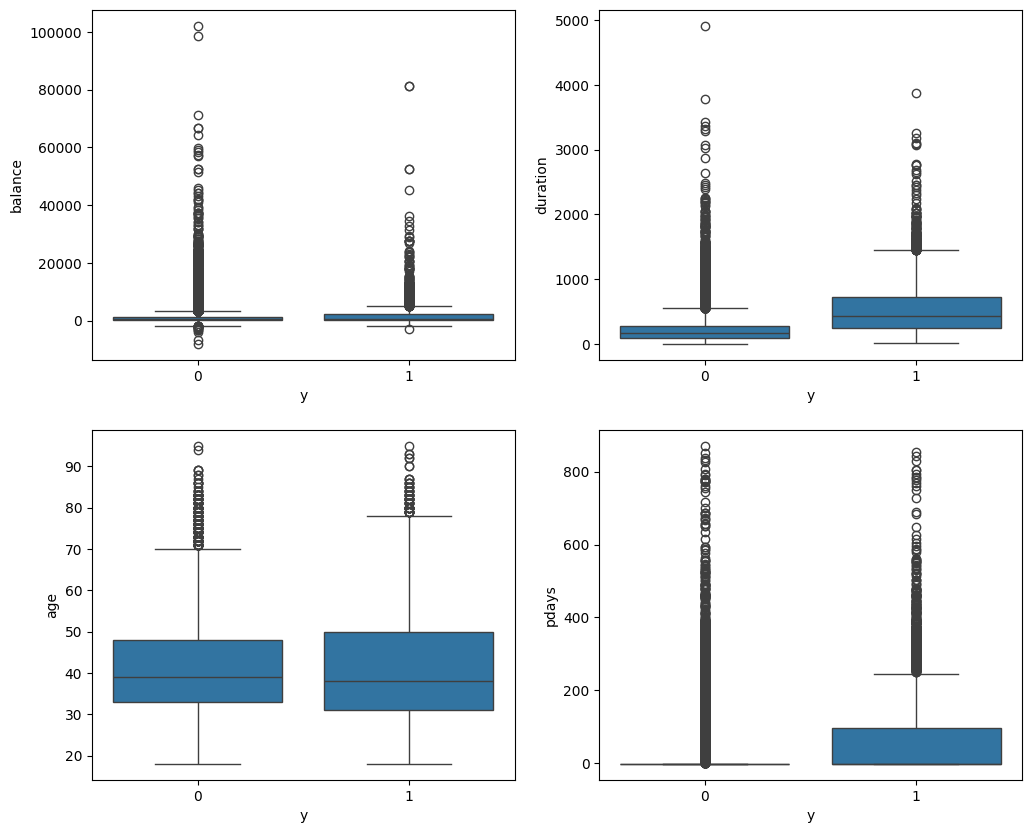

In [101]:
#More plots for the users that have subscribed - comparison using boxplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,10))
sns.boxplot(x='y', y='balance', data=df, ax=ax1)
sns.boxplot(x='y', y='duration', data=df, ax=ax2)
sns.boxplot(x='y', y='age', data=df, ax=ax3)
sns.boxplot(x='y', y='pdays', data=df, ax=ax4)

<Axes: xlabel='age', ylabel='balance'>

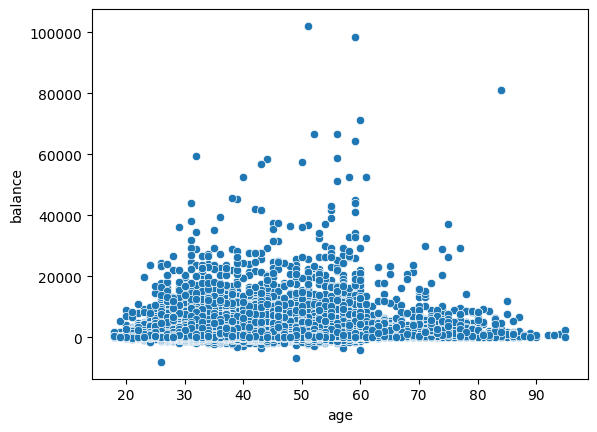

In [102]:
sns.scatterplot(x=df['age'], y=df['balance'])

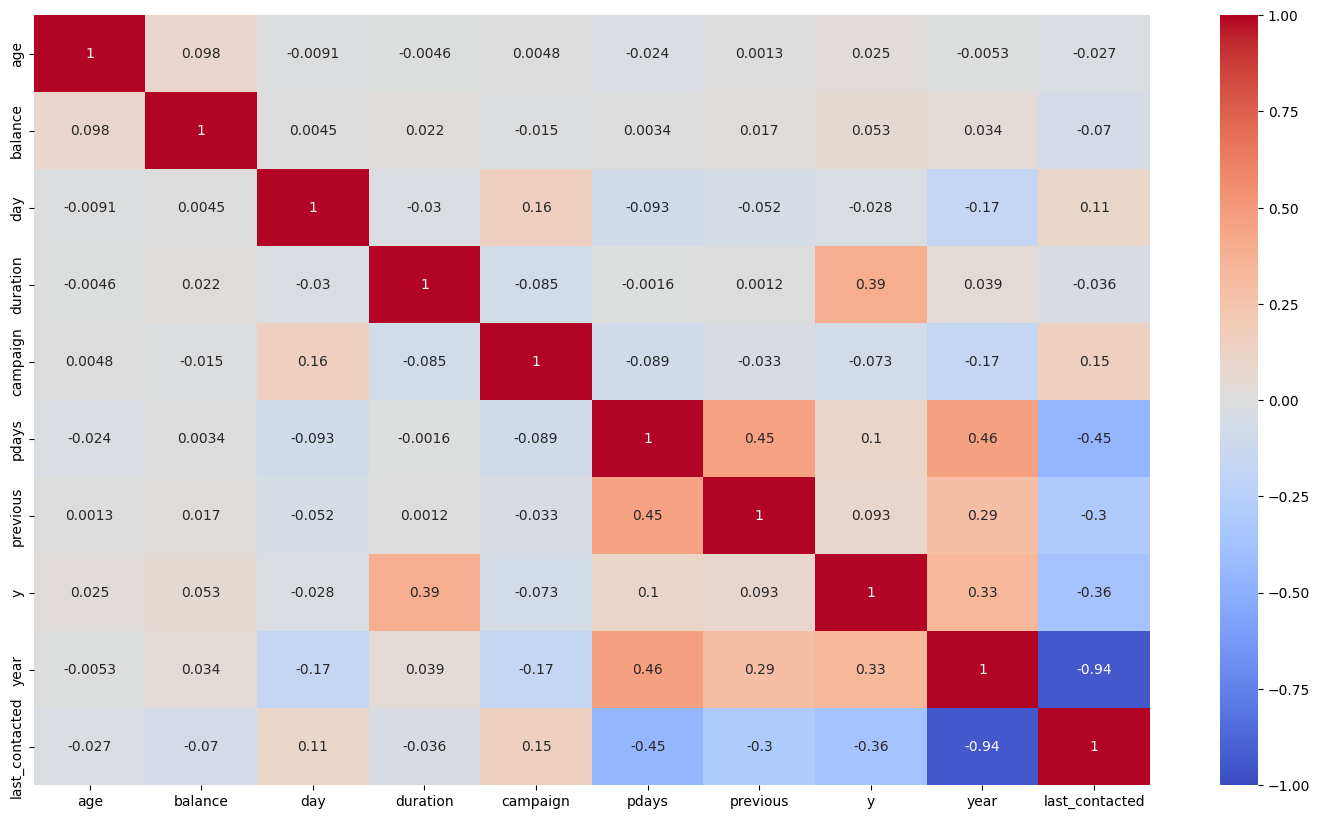

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1534/2454456081.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')


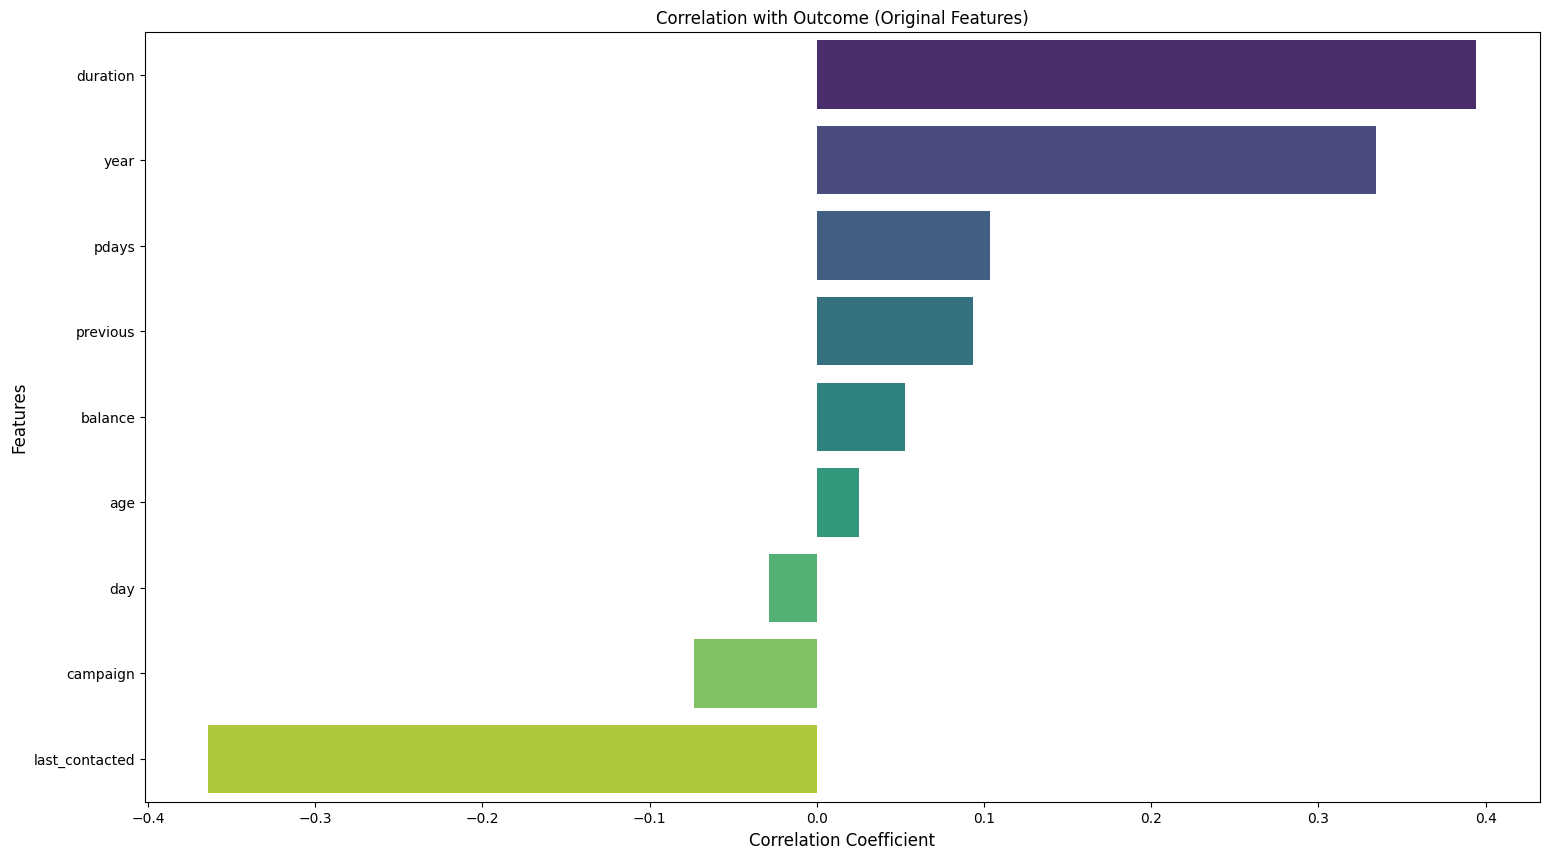

In [103]:
#Correlation and heatmap matrix

corr_matrix = df.corr(numeric_only=True)
sub_corr = corr_matrix['y'].drop('y').sort_values(ascending=False)

#Heatmap
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

#Correlation Matrix
plt.figure(figsize=(18,10))
sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')
plt.title('Correlation with Outcome (Original Features)')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()



Duration seems to have the highest correlation with the outcome variable with pdays, previous
and balance having the next largest positive correlation.

Balance and pdays could be less of a factor once outliers have been dealt with.

Campaign has the largest negative correlation with the outcome variable

In [104]:
#Correlation and heatmap included with the categorical or binary variables

labelecoder = LabelEncoder()

enc_df = df.copy()

encoding_col = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

for col in encoding_col:
    enc_df[col] = labelecoder.fit_transform(enc_df[col])

enc_df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,age_cut,year,date,last_contacted
0,58,4,1,2,0,2143,1,0,2,5,...,261,1,-1,0,3,0,"(52.0, 95.0]",2008,2008-05-05,970
1,44,9,2,1,0,29,1,0,2,5,...,151,1,-1,0,3,0,"(39.0, 45.0]",2008,2008-05-05,970
2,33,2,1,1,0,2,1,1,2,5,...,76,1,-1,0,3,0,"(31.0, 35.0]",2008,2008-05-05,970
3,47,1,1,3,0,1506,1,0,2,5,...,92,1,-1,0,3,0,"(45.0, 52.0]",2008,2008-05-05,970
4,33,11,2,3,0,1,0,0,2,5,...,198,1,-1,0,3,0,"(31.0, 35.0]",2008,2008-05-05,970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,...,977,3,-1,0,3,1,"(45.0, 52.0]",2010,2010-11-17,44
45207,71,5,0,0,0,1729,0,0,0,17,...,456,2,-1,0,3,1,"(52.0, 95.0]",2010,2010-11-17,44
45208,72,5,1,1,0,5715,0,0,0,17,...,1127,5,184,3,2,1,"(52.0, 95.0]",2010,2010-11-17,44
45209,57,1,1,1,0,668,0,0,1,17,...,508,4,-1,0,3,0,"(52.0, 95.0]",2010,2010-11-17,44


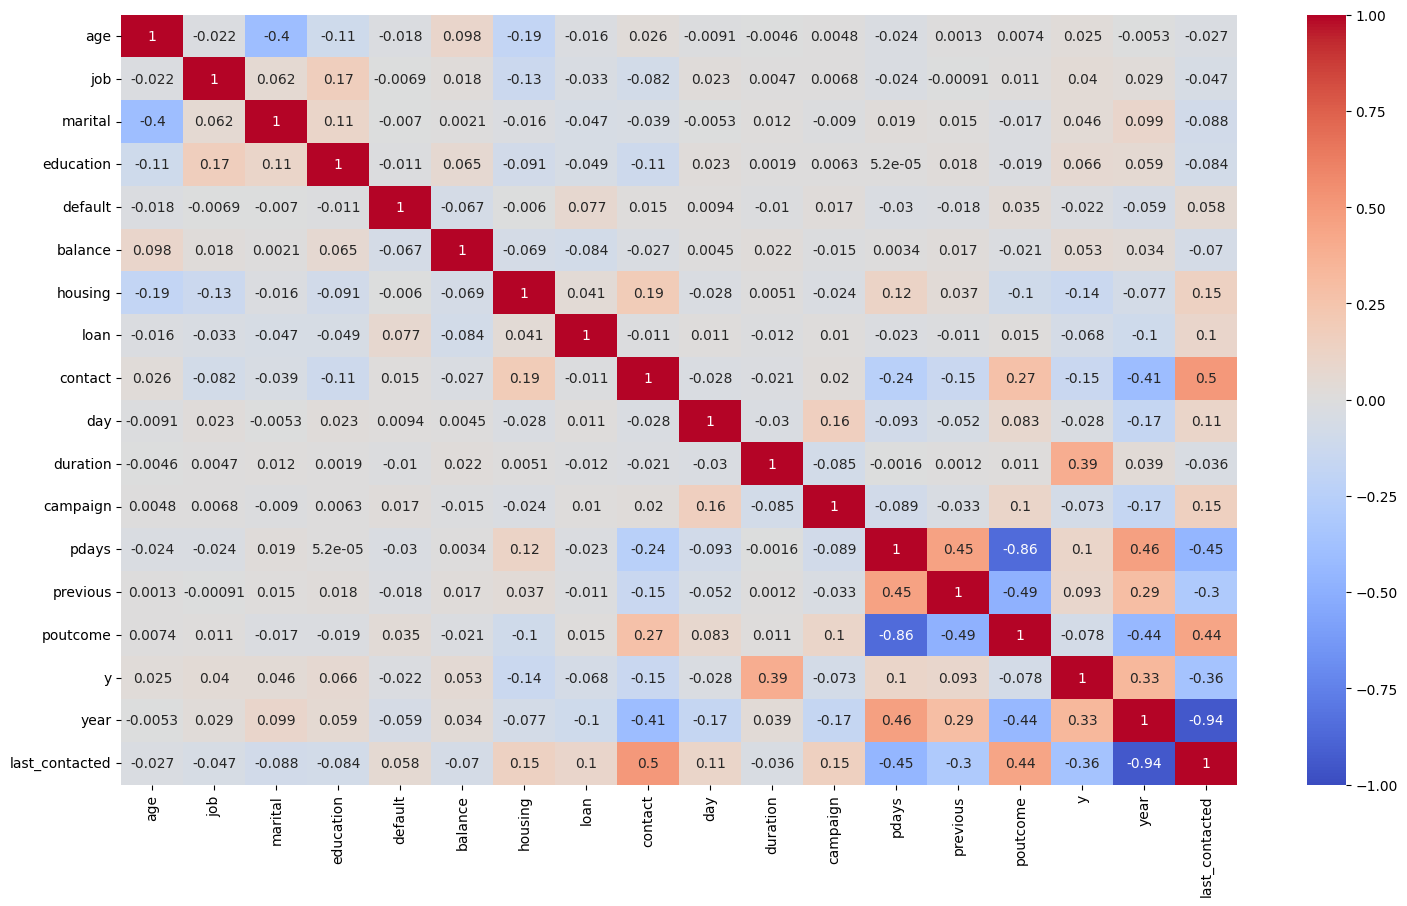

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1534/502674068.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')


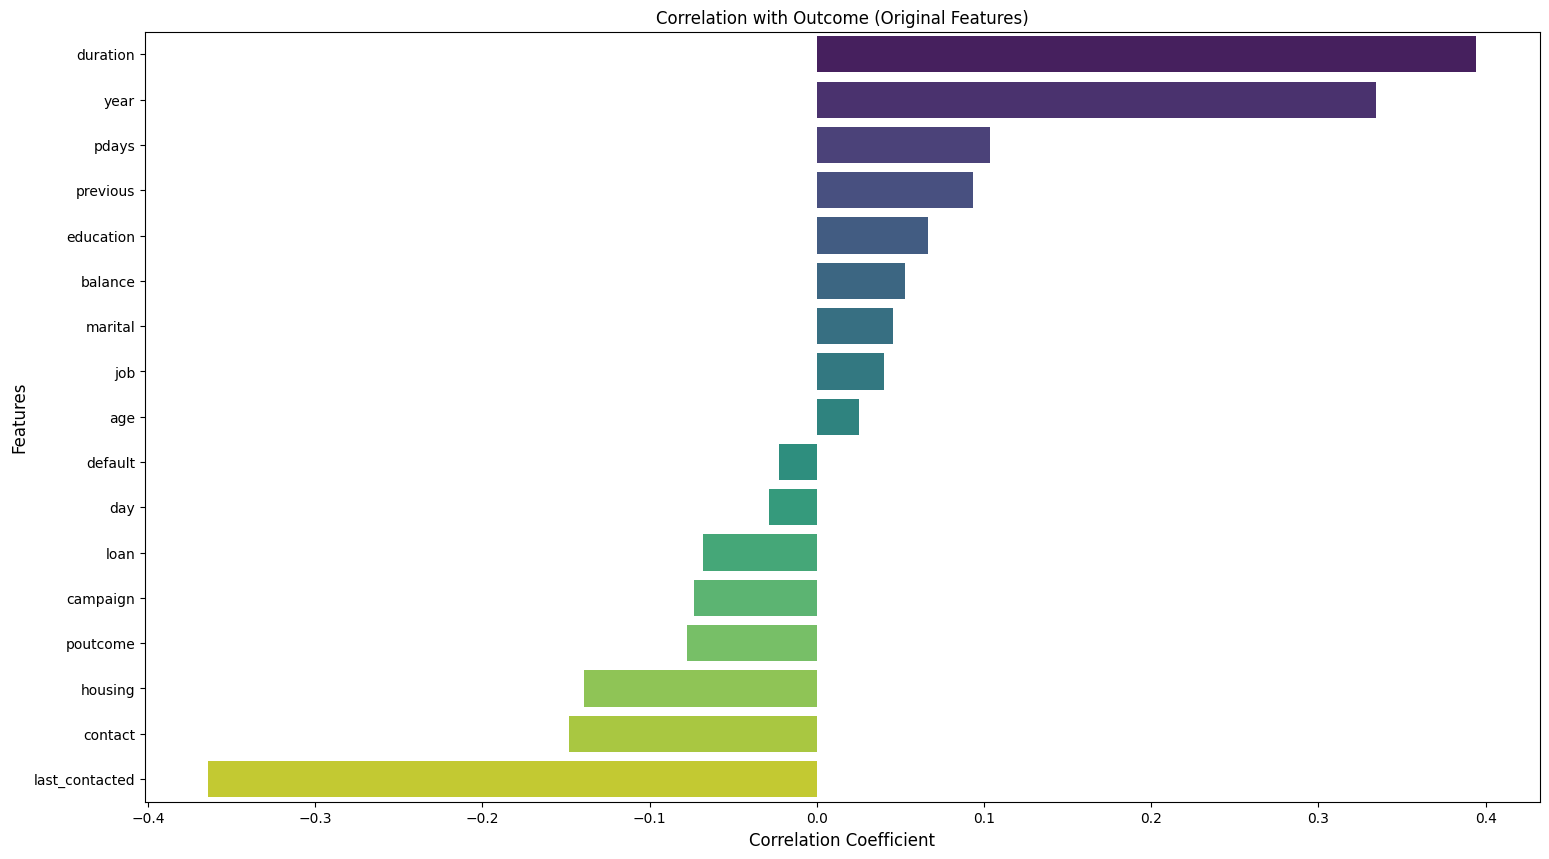

In [105]:
# Correlation matrix

corr_matrix = enc_df.corr(numeric_only=True)
sub_corr = corr_matrix['y'].drop('y').sort_values(ascending=False)

#Heatmap
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

#Correlation Matrix
plt.figure(figsize=(18,10))
sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')
plt.title('Correlation with Outcome (Original Features)')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

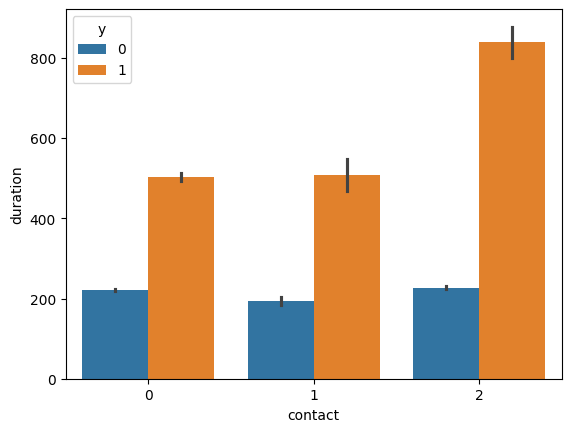

In [106]:
#Going to further explore the duration, contact, and housing variables

sns.barplot(x='contact', y='duration', hue='y', data=enc_df)
plt.show()

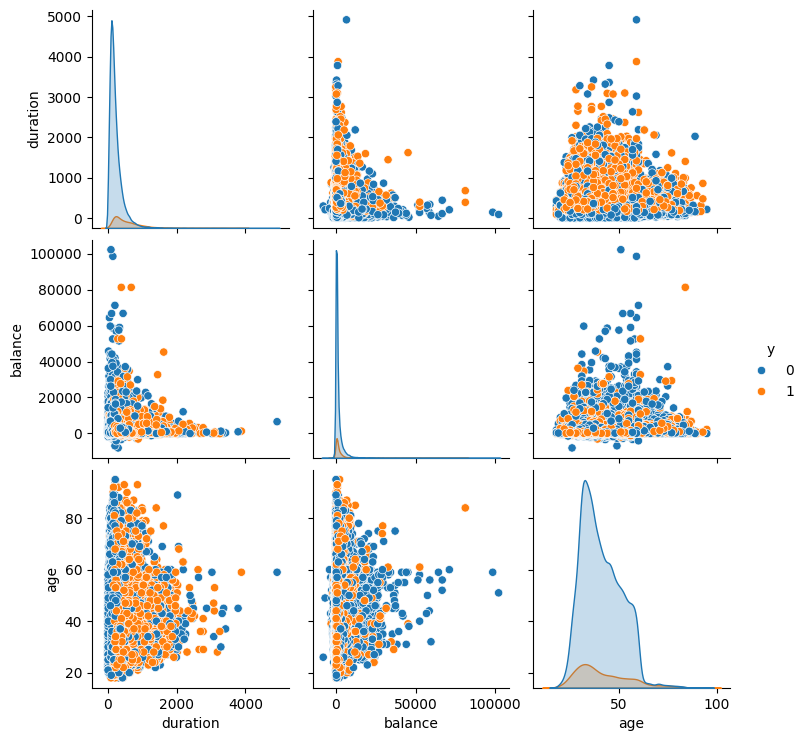

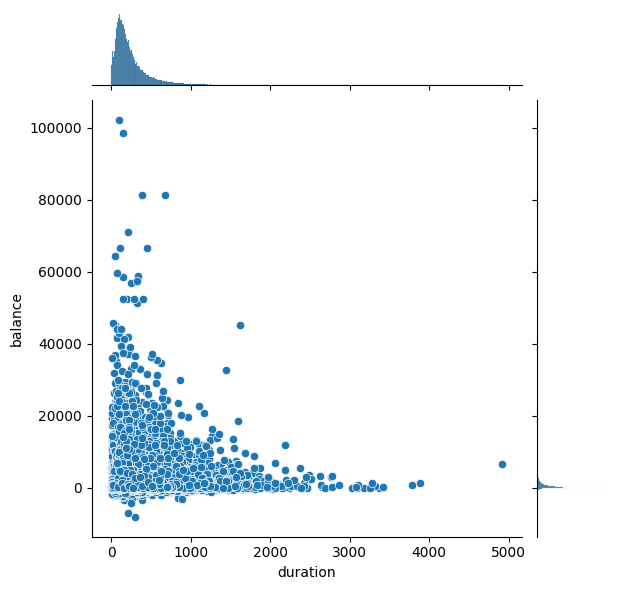

In [107]:
sns.pairplot(df[['duration', 'balance', 'age', 'y']], hue='y')
sns.jointplot(x='duration', y='balance', data=df, kind='scatter')

It seems theres a difference in comparison for those who purchase bank term deposits, they all have on average larger durations than those who did not subscribe to a term deposit

In [108]:
enc_df['contact'].value_counts().reset_index()

,contact,count
0,0,29285
1,2,13020
2,1,2906


In [109]:
df['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

In [110]:
duration = enc_df.groupby('y')['duration'].mean()
duration

y
0    221.182806
1    537.294574
Name: duration, dtype: float64

In [111]:
# creating separate dataframe using the strongest coefficient avg for has the client subscribed to term deposit to segment data as an attempt to re-balance
duration_df = enc_df[(enc_df['duration'] >= 537)]
duration_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,age_cut,year,date,last_contacted
37,53,9,1,1,0,-3,0,0,2,5,...,1666,1,-1,0,3,0,"(52.0, 95.0]",2008,2008-05-05,970
38,36,0,0,1,0,506,1,0,2,5,...,577,1,-1,0,3,0,"(35.0, 39.0]",2008,2008-05-05,970
43,54,5,1,1,0,529,1,0,2,5,...,1492,1,-1,0,3,0,"(52.0, 95.0]",2008,2008-05-05,970
44,58,5,1,3,0,96,1,0,2,5,...,616,1,-1,0,3,0,"(52.0, 95.0]",2008,2008-05-05,970
53,42,0,2,1,0,-76,1,0,2,5,...,787,1,-1,0,3,0,"(39.0, 45.0]",2008,2008-05-05,970


In [112]:
duration_df['y'].value_counts()

y
0    2597
1    2099
Name: count, dtype: int64

In [113]:
duration_df['contact'].value_counts()

contact
0    3166
2    1271
1     259
Name: count, dtype: int64

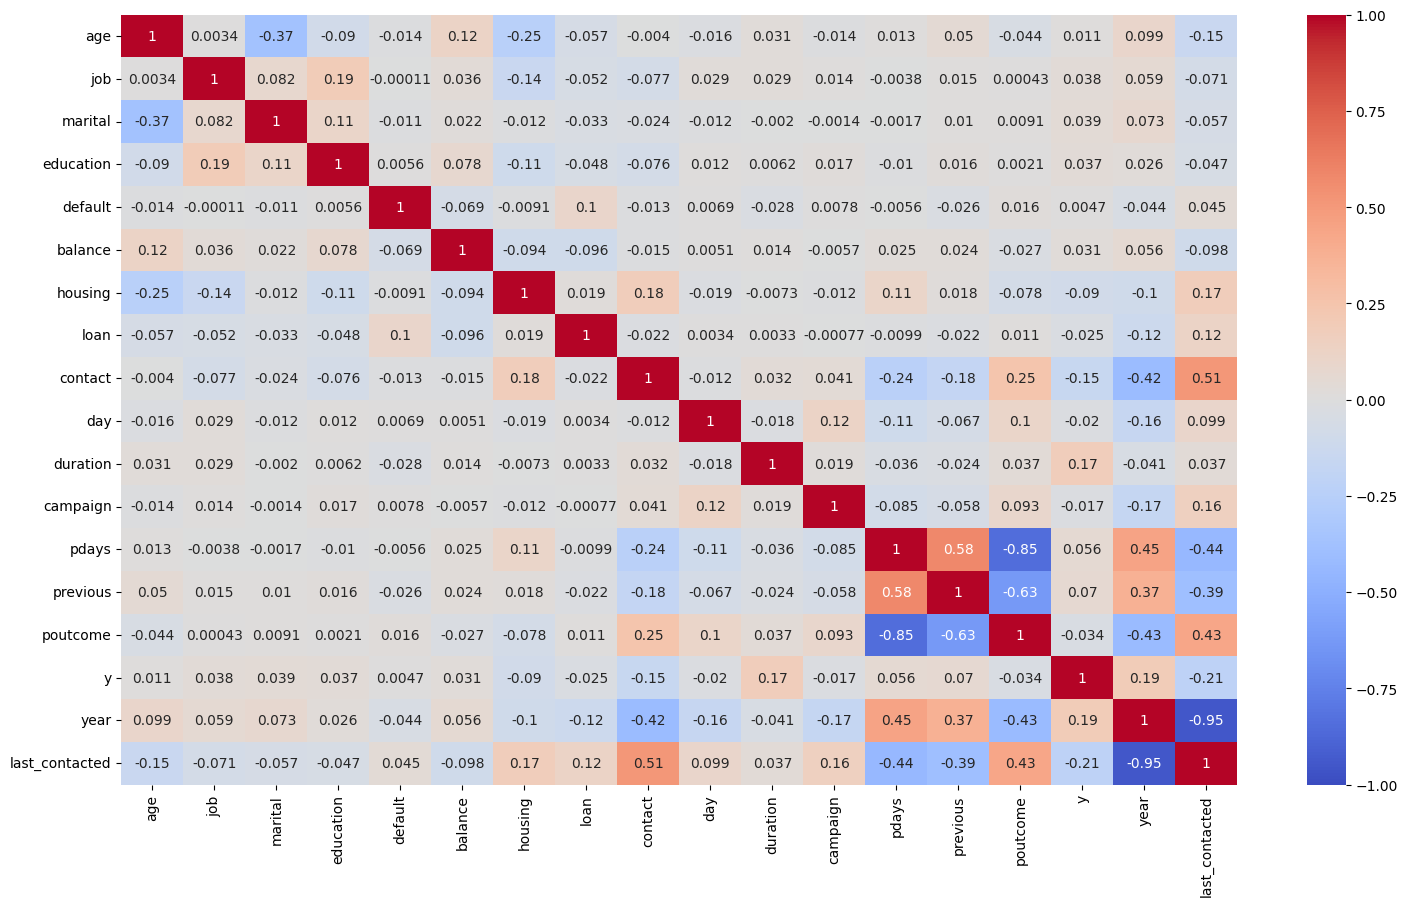

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1534/1411010685.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')


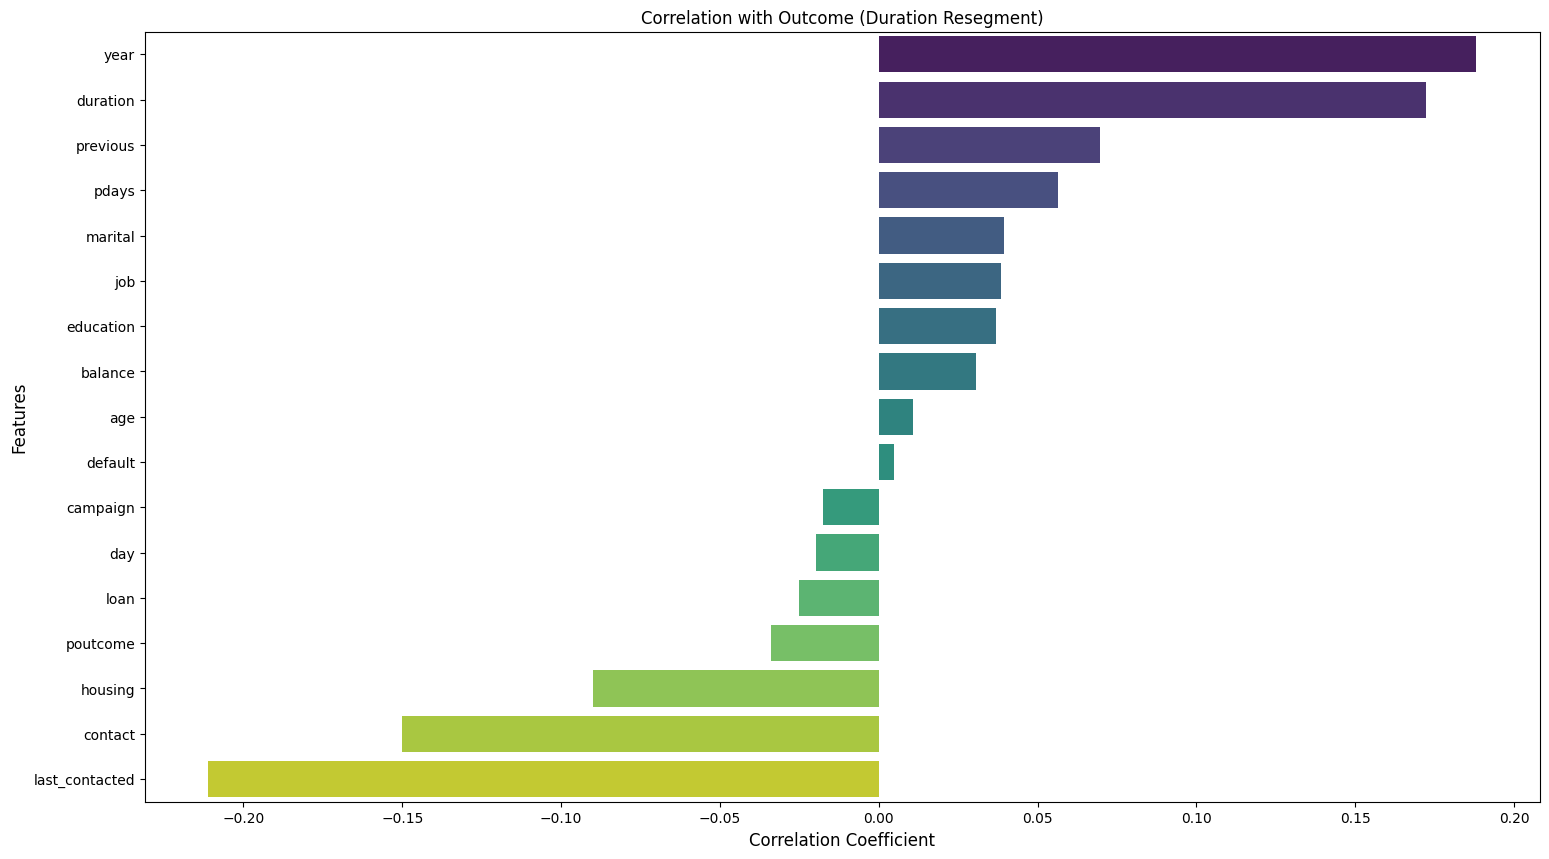

In [114]:
# Correlation matrix
corr_matrix = duration_df.corr(numeric_only=True)
sub_corr = corr_matrix['y'].drop('y').sort_values(ascending=False)

#Heatmap
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

#Correlation Matrix
plt.figure(figsize=(18,10))
sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')
plt.title('Correlation with Outcome (Duration Resegment)')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

## Feature Engineering

One hot encoding with all the binary columns
Converting the Day and Month column to its own datetime feature
Convert the continuous variable of "Balance" into a categorical variable

In [115]:
#Converting balance to categorical (High, Medium, Low) - ** More optimization, remove the outliers and find out the more accurate quantiles

def money_class(x):
    if x >= 1500:
        return 'High'
    elif x < 1499 & x >= 750:
        return 'Medium'
    else:
        return 'Low'


df['m_class'] = df['balance'].apply(money_class)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,pdays,previous,poutcome,y,age_cut,year,date,last_contacted,m_class
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,1,-1,0,unknown,0,"(52.0, 95.0]",2008,2008-05-05,970,High
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,1,-1,0,unknown,0,"(39.0, 45.0]",2008,2008-05-05,970,Low
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,1,-1,0,unknown,0,"(31.0, 35.0]",2008,2008-05-05,970,Low
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,1,-1,0,unknown,0,"(45.0, 52.0]",2008,2008-05-05,970,High
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,1,-1,0,unknown,0,"(31.0, 35.0]",2008,2008-05-05,970,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,...,3,-1,0,unknown,1,"(45.0, 52.0]",2010,2010-11-17,44,Low
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,...,2,-1,0,unknown,1,"(52.0, 95.0]",2010,2010-11-17,44,High
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,...,5,184,3,success,1,"(52.0, 95.0]",2010,2010-11-17,44,High
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,...,4,-1,0,unknown,0,"(52.0, 95.0]",2010,2010-11-17,44,Low


In [116]:
#Extra summary
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome,m_class
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,Low
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,30669


In [117]:
def money_class_num(x):
    if x >= 1500:
        return '2'
    elif x < 1499 & x >= 750:
        return '1'
    else:
        return '0'

enc_df['money_level'] = df['balance'].apply(money_class_num)

In [118]:
enc_df['money_level'] = enc_df['money_level'].astype(int)
enc_df['money_level'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 45211 entries, 0 to 45210
Series name: money_level
Non-Null Count  Dtype
--------------  -----
45211 non-null  int64
dtypes: int64(1)
memory usage: 353.3 KB


## Model Building

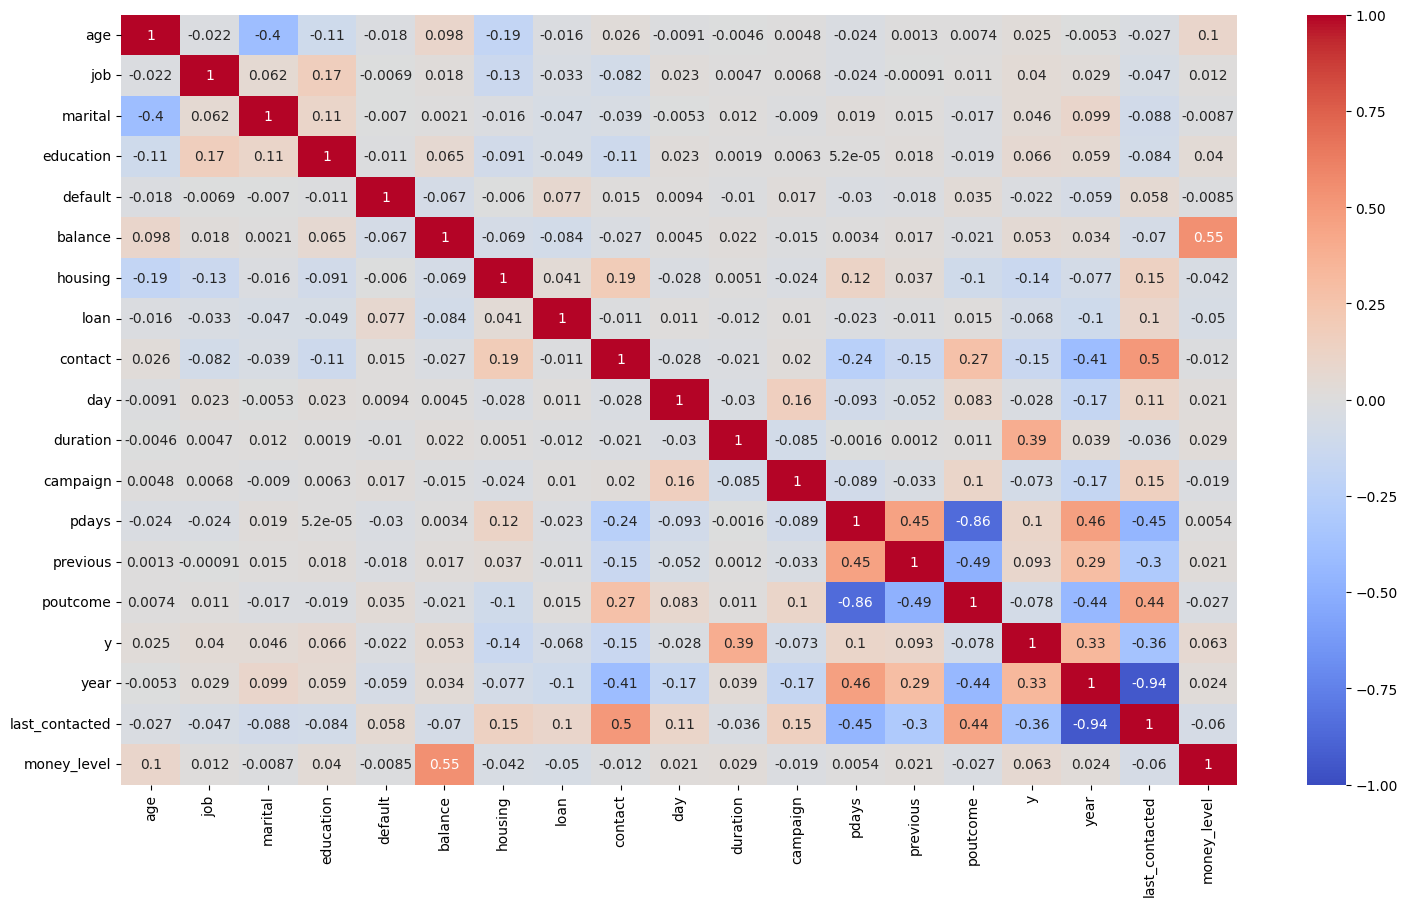

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1534/502674068.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')


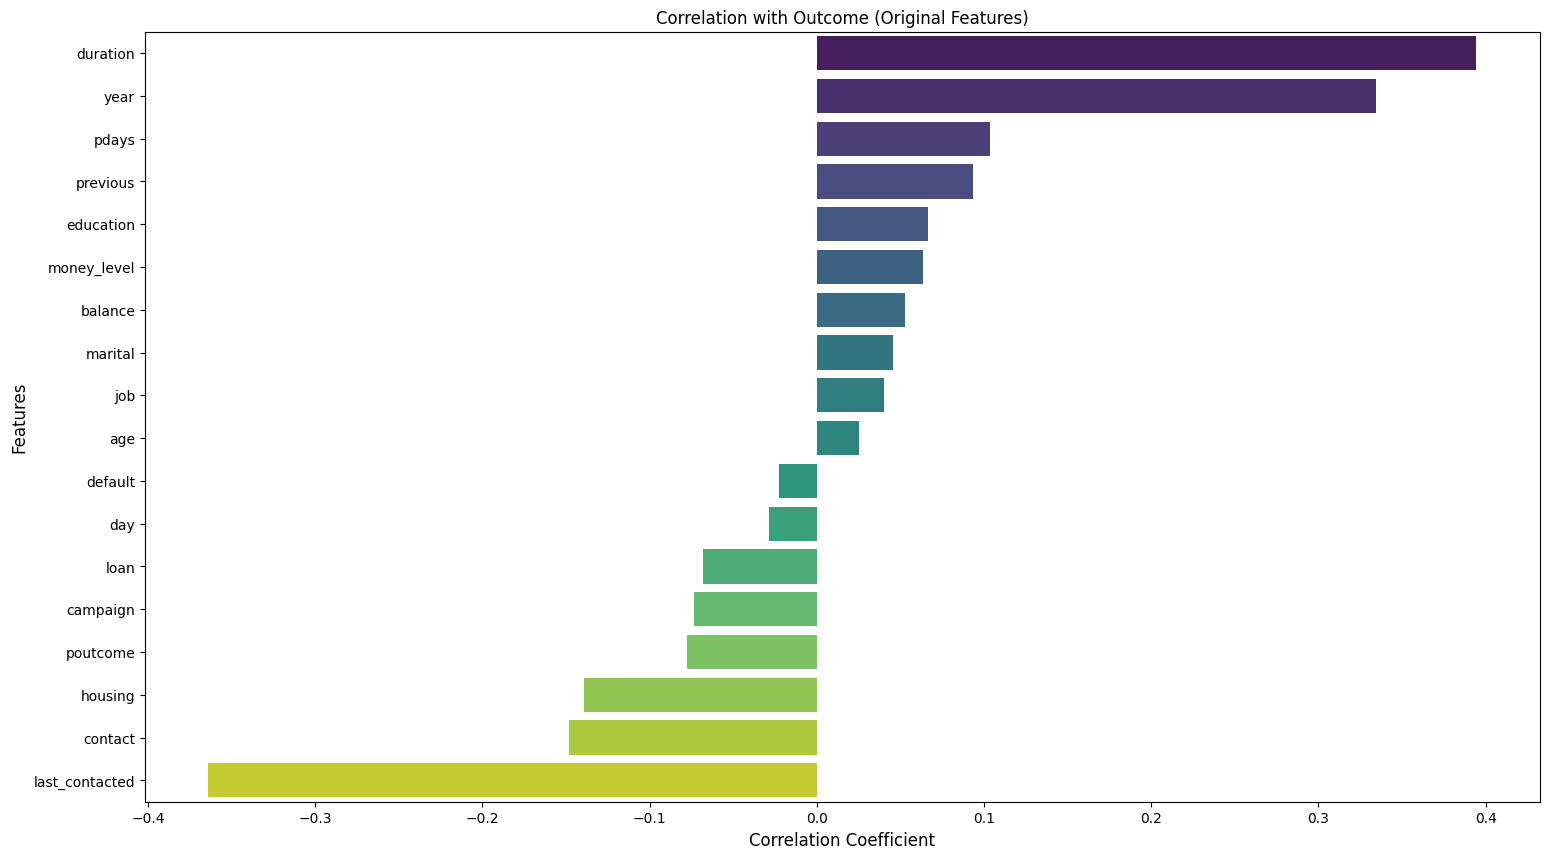

In [119]:
# Correlation matrix

corr_matrix = enc_df.corr(numeric_only=True)
sub_corr = corr_matrix['y'].drop('y').sort_values(ascending=False)

#Heatmap
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

#Correlation Matrix
plt.figure(figsize=(18,10))
sns.barplot(x=sub_corr.values, y=sub_corr.index, palette='viridis')
plt.title('Correlation with Outcome (Original Features)')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

In [120]:
X = enc_df[['duration', 'previous', 'pdays', 'contact', 'housing', 'year', 'last_contacted']]
y = enc_df['y']

In [121]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [122]:
categorical = ['housing', 'contact']
numerical = ['duration', 'pdays', 'previous', 'last_contacted', 'year']

In [123]:
#Preprocessing pipeline

catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
numTransformer = Pipeline(steps = [('scaler', MinMaxScaler())])
ordTransformer = Pipeline(steps = [('ord', OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, categorical), ('num', numTransformer, numerical)])
#('ord', ordTransformer, ordinal)

In [124]:
#Logistic regression Model - Basic

logreg = Pipeline(steps=[('preprocessor', preprocessor), ('logistic', LogisticRegression())])

logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, pred, average='binary')
print("Precision: ", precision)
recall = recall_score(y_test, pred, average='binary')
print("Recall: ", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1: ", f1)

Accuracy:  0.897817752875258
Precision:  0.6299019607843137
Recall:  0.3216520650813517
F1:  0.4258492129246065


Results are quite low given the varibles fed into the model. Precision is lackluster leading to only a 60% amount of True positives the model is predicting. Recall is very low (31%) which signifies the model is predicting a high amount of false negatives. For the business this would be costly due to the model not being able to identify target users who would subscribe to the term deposit and therefore it would have a direct impact on revenue. In order for this model to be efficient, Recall should be prioritized and increased to minimize the volume of false negatives to capture as many subscribers at possible, even if its at a cost of allowing some false positives.

In [125]:
# Parameter tuning and grid search for Logistic Regression

param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2', 'elasticnet'],
    'logistic__solver': ['saga']  # saga solver supports l1, l2, and elasticnet
}

# Use GridSearchCV to find the best hyperparameter combination
grid_search = GridSearchCV(logreg, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

# Output the best hyperparameter combination
print("Best hyperparameters for Logistic Regression:", grid_search.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters for Logistic Regression: {'logistic__C': 100, 'logistic__penalty': 'l1', 'logistic__solver': 'saga'}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

In [126]:
#Final pipeline for Logistic 

logreg = Pipeline(steps= [('preprocessor', preprocessor), ('logistic', LogisticRegression(C=100, penalty='l1', solver='saga'))])

logreg.fit(X_train, y_train)

pred = logreg.predict(X_test)

# performance metrics (binary)
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)
precision = precision_score(y_test, pred)
print("Precision:", precision)
recall = recall_score(y_test, pred, average='binary')
print("Recall Score:", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1 Score:", f1)


# cross validation
crossVal = cross_val_score(logreg, X_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

report_logreg_grid = classification_report(y_test, pred)
print(report_logreg_grid)

Accuracy: 0.8987024476555588
Precision: 0.6252796420581656
Recall Score: 0.3498122653316646
F1 Score: 0.44863563402889245
Cross Validation F1 Scores: [0.42307692 0.40773286 0.44290657 0.42857143 0.45486111 0.40665434
 0.43006993 0.44639719 0.48414023 0.4862069 ]
Mean cross validation F1 Score: 0.4410617494030292
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.63      0.35      0.45      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.66      0.70     13564
weighted avg       0.88      0.90      0.89     13564



In [127]:
#KNN model - Basic

knn = Pipeline(steps=[('preprocessor', preprocessor), ('knn', KNeighborsClassifier())])

knn.fit(X_train, y_train)
pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, pred, average='binary')
print("Precision: ", precision)
recall = recall_score(y_test, pred, average='binary')
print("Recall: ", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1: ", f1)

Accuracy:  0.9017251548215865
Precision:  0.5973548861131521
Recall:  0.5087609511889862
F1:  0.5495099695843191


In [128]:
#Parameter tuning and Grid Search for KNN

param_grid = {
    'knn__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['housing',
                                                                          'contact']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['duration',
                                                                          'pdays',
                                                                          'previous',
                                                                          'last_contacted',
                                                                          'year'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [129]:
# Output the best hyperparameter combination
print("Best hyperparameters for KNN:", grid_search.best_params_)

Best hyperparameters for KNN: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}


In [130]:
#Final Pipeline for KNN

knn = Pipeline(steps= (['preprocessor', preprocessor], ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=45, weights='uniform'))))

knn.fit(X_train, y_train)

pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, pred, average='binary')
print("Precision: ", precision)
recall = recall_score(y_test, pred, average='binary')
print("Recall: ", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1: ", f1)

# cross validation
crossVal = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')

# print scores
print("Cross Validation F1 Scores:", crossVal)
print("Mean cross validation F1 Score:", np.mean(crossVal))

report_knn_grid = classification_report(y_test, pred)
print(report_knn_grid)

Accuracy:  0.9034945443821881
Precision:  0.62382176520994
Recall:  0.4555694618272841
F1:  0.5265822784810127
Cross Validation F1 Scores: [0.46078431 0.5        0.51782946 0.49315068 0.51104101 0.53061224
 0.53160454 0.49520767 0.53918495 0.52357724]
Mean cross validation F1 Score: 0.5102992104952583
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     11966
           1       0.62      0.46      0.53      1598

    accuracy                           0.90     13564
   macro avg       0.78      0.71      0.74     13564
weighted avg       0.89      0.90      0.90     13564



In [131]:
#Random Forest - Basic
rf = Pipeline(steps=[('preprocessor', preprocessor), ('rf', RandomForestClassifier())])

rf.fit(X_train, y_train)
pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, pred, average='binary')
print("Precision: ", precision)
recall = recall_score(y_test, pred, average='binary')
print("Recall: ", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1: ", f1)

Accuracy:  0.9042317900324388
Precision:  0.6021872863978127
Recall:  0.5513141426783479
F1:  0.5756288794511597


In [132]:
#Random Forest Final Pipeline
# Define hyperparameter grid
param_grid = {
    'rf__n_estimators': [200],
    'rf__max_depth': [10],
    'rf__min_samples_split': [2],
    'rf__min_samples_leaf': [4]
}

# Use GridSearchCV to find the best hyperparameter combination
grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

# Output the best hyperparameter combination
print("Best hyperparameters for Random Forest:", grid_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters for Random Forest: {'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Use the best parameters obtained from GridSearchCV
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 4
}

# Initialize the RandomForestClassifier with the best parameters
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Fit the model to the training data
rf_best.fit(X_train, y_train)

# Predict the test data
y_pred = rf_best.predict(X_test)

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11966
           1       0.65      0.53      0.58      1598

    accuracy                           0.91     13564
   macro avg       0.80      0.74      0.77     13564
weighted avg       0.90      0.91      0.91     13564



In [134]:
# AdaBoost - Basic
ada = Pipeline(steps=[('preprocessor', preprocessor), ('ada', AdaBoostClassifier())])

ada.fit(X_train, y_train)
pred = ada.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print("Accuracy: ", accuracy)
precision = precision_score(y_test, pred, average='binary')
print("Precision: ", precision)
recall = recall_score(y_test, pred, average='binary')
print("Recall: ", recall)
f1 = f1_score(y_test, pred, average='binary')
print("F1: ", f1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.8975228546151578
Precision:  0.631979695431472
Recall:  0.311639549436796
F1:  0.41743503772003354


In [135]:
# Grid search for Adaboost model
param_grid = {
    'ada__n_estimators': [50, 100, 200],  # Number of estimators (weak learners)
    'ada__learning_rate': [0.01, 0.1, 1, 1.5],  # Learning rate controls the contribution of each weak learner
    'ada__algorithm': ['SAMME', 'SAMME.R']  # Different boosting algorithms
}

ada = Pipeline(steps=[('preprocessor', preprocessor), ('ada', AdaBoostClassifier())])
grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding best score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Best Parameters:  {'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 1.5, 'ada__n_estimators': 200}
Best F1 Score:  0.49737398317043785


In [136]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

# Best hyperparameters obtained from previous tuning
best_params = {
    'n_estimators': 200,    # Example: best number of estimators found
    'learning_rate': 1.5    # Example: best learning rate found
}

# Initialize AdaBoostClassifier with the best hyperparameters
ada_best = AdaBoostClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)

# Fit the model to the training data
ada_best.fit(X_train, y_train)

# Predict on the test set
y_pred = ada_best.predict(X_test)

# Generate and print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95     11966
           1       0.65      0.40      0.50      1598

    accuracy                           0.90     13564
   macro avg       0.79      0.69      0.72     13564
weighted avg       0.89      0.90      0.89     13564



In [137]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming enc_df is your preprocessed DataFrame
# Replace 'base_estimator' with 'estimator'
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)

# Train the model
bagging_clf.fit(X_train, y_train)

# Predict using the test set
y_pred = bagging_clf.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     11966
           1       0.58      0.50      0.54      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.73      0.74     13564
weighted avg       0.89      0.90      0.90     13564



In [138]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees
    'max_samples': [0.5, 1.0],      # Fraction of samples to draw for each base estimator
    'max_features': [0.5, 1.0],     # Fraction of features to draw for each base estimator
    'bootstrap': [True, False],     # Whether samples are drawn with or without replacement
    'estimator__max_depth': [3, 5, 10]  # Max depth of the decision tree
}

# Create a Bagging Classifier with a Decision Tree base estimator
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'bootstrap': True, 'estimator__max_depth': 10, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}
Best Score: 0.9103550371331645
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     11966
           1       0.64      0.59      0.62      1598

    accuracy                           0.91     13564
   macro avg       0.79      0.77      0.78     13564
weighted avg       0.91      0.91      0.91     13564



Bagging using KNN as the estimator (was not a good choice)

In [139]:
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, n_jobs=1, verbose=1)

In [140]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50],      # Number of trees (reduced for speed)
    'max_samples': [0.5, 1.0],     # Fraction of samples to draw
    'max_features': [0.5, 1.0],    # Fraction of features to draw
    'bootstrap': [True, False]     # Sampling with/without replacement
}

# Create a Bagging Classifier with KNeighborsClassifier as base estimator
bagging_clf = BaggingClassifier(estimator=KNeighborsClassifier(), random_state=42)

# Use GridSearchCV with single-threading (n_jobs=1)
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'bootstrap': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Best Score: 0.9020446915911785
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11966
           1       0.63      0.51      0.56      1598

    accuracy                           0.91     13564
   macro avg       0.78      0.73      0.75     13564
weighted avg       0.90      0.91      0.90     13564



Bagging with Random Forest as estimator

In [141]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a reduced parameter grid
param_grid = {
    'n_estimators': [10, 20],  # Reduced number of trees
    'max_samples': [0.7, 1.0],  # Reduced number of max_samples
    'max_features': [0.7, 1.0],  # Reduced number of max_features
    'bootstrap': [True]  # Fixed to True, avoiding extra combination checks
}

# Create a Bagging Classifier with RandomForestClassifier as base estimator
bagging_clf = BaggingClassifier(estimator=RandomForestClassifier(), random_state=42)

# Use GridSearchCV with reduced cross-validation folds (cv=3)
grid_search = GridSearchCV(bagging_clf, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Hyperparameters: {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 20}
Best Score: 0.9055202704837741
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     11966
           1       0.64      0.57      0.60      1598

    accuracy                           0.91     13564
   macro avg       0.79      0.76      0.78     13564
weighted avg       0.91      0.91      0.91     13564



Bagging with LogReg as estimator (using 10, 20 as estimators takes way too long - well over 7 minutes to run)

In [142]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 20],      # Number of trees (reduced for speed)
    'max_samples': [0.7, 1.0],     # Fraction of samples to draw
    'max_features': [0.7, 1.0],    # Fraction of features to draw
    'bootstrap': [True, False]     # Sampling with/without replacement
}

# Create a Bagging Classifier with LogisticRegression as base estimator
bagging_clf = BaggingClassifier(estimator=LogisticRegression(max_iter=1000), random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'bootstrap': True, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
Best Score: 0.8987899827694529
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.61      0.34      0.44      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.66      0.69     13564
weighted avg       0.88      0.90      0.88     13564



Bagging with SVC as estimator (set estimator to 10, 15 and it took 11+ minutes)


In [143]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 15],      # Number of trees (reduced for speed)
    'max_samples': [0.7, 1.0],     # Fraction of samples to draw
    'max_features': [0.7, 1.0],    # Fraction of features to draw
    'bootstrap': [True, False]     # Sampling with/without replacement
}

# Create a Bagging Classifier with SVC as base estimator
bagging_clf = BaggingClassifier(estimator=SVC(), random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, n_jobs=1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict with the best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

Using random oversampling with bagging

In [144]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Apply Random Oversampling (convert y_train to 1D array using .ravel())
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train.values.ravel())

# Create the Bagging Classifier using SVC as the base estimator
bagging_clf = BaggingClassifier(estimator=SVC(), random_state=42)

# Define a reduced parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10],  # Reduced the number of estimators for faster processing
    'max_samples': [0.8],  # Fixed max_samples to reduce grid search combinations
    'bootstrap': [True]    # Fixed bootstrap to True for simplicity
}

# Perform Grid Search with reduced cv (cv=3) and parallel processing (n_jobs=-1)
grid_search = GridSearchCV(bagging_clf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Predict with the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.79      0.88     11966
           1       0.36      0.89      0.52      1598

    accuracy                           0.80     13564
   macro avg       0.67      0.84      0.70     13564
weighted avg       0.91      0.80      0.83     13564



SMOTE with bagging

In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

# Generate a balanced dataset with the specified requirements
X, y = make_classification(n_samples=40000, n_features=7, n_informative=2, 
                           n_redundant=2, n_clusters_per_class=1, 
                           weights=[0.8, 0.2], flip_y=0, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SMOTE object for oversampling on the training data only
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=3)

# Constrained decision tree with balanced class weights
base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight='balanced')

# Bagging classifier with tuned parameters
bagging_clf = BaggingClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    max_samples=0.8,  # Subsample data to introduce variance
    max_features=0.8,  # Use a subset of features
    random_state=42
)

# Reduce features using PCA
pca = PCA(n_components=5)  # Reducing to 5 components, since you have 7 features

# Apply SMOTE on training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create the pipeline (note that we fit the pipeline after resampling the data)
pipeline = Pipeline([
    ('pca', pca),  # Apply PCA
    ('classifier', bagging_clf)  # Use bagging classifier
])

# Fit the pipeline on the resampled training data
pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set (without applying SMOTE to the test data)
y_pred = pipeline.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6444
           1       0.73      0.77      0.75      1556

    accuracy                           0.90      8000
   macro avg       0.84      0.85      0.84      8000
weighted avg       0.90      0.90      0.90      8000



In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

# Generate a balanced dataset with the specified requirements
X, y = make_classification(n_samples=40000, n_features=7, n_informative=2, 
                           n_redundant=2, n_clusters_per_class=1, 
                           weights=[0.8, 0.2], flip_y=0, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SMOTE object for oversampling on the training data only
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=3)

# Constrained decision tree with balanced class weights
base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight='balanced')

# Bagging classifier with tuned parameters
bagging_clf = BaggingClassifier(
    estimator=base_estimator, 
    n_estimators=50, 
    max_samples=0.8,  # Subsample data to introduce variance
    max_features=0.8,  # Use a subset of features
    random_state=42
)

# Reduce features using PCA
pca = PCA(n_components=5)  # Reducing to 5 components, since you have 7 features

# Apply SMOTE on training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create the pipeline (note that we fit the pipeline after resampling the data)
pipeline = Pipeline([
    ('pca', pca),  # Apply PCA
    ('classifier', bagging_clf)  # Use bagging classifier
])

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the pipeline with cross-validation on the resampled training data
cv_scores = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=cv, scoring='f1')

# Print cross-validation scores
print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")

# Fit the pipeline on the resampled training data
pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set (without applying SMOTE to the test data)
y_pred = pipeline.predict(X_test)

# Generate the classification report on the test set
report = classification_report(y_test, y_pred)
print(report)

Cross-Validation F1 Scores: [0.81745544 0.81230895 0.82516909 0.82091076 0.82064885]
Mean F1 Score: 0.8193
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6444
           1       0.73      0.77      0.75      1556

    accuracy                           0.90      8000
   macro avg       0.84      0.85      0.84      8000
weighted avg       0.90      0.90      0.90      8000



In [171]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

# Generate a balanced dataset with the specified requirements
X, y = make_classification(n_samples=40000, n_features=7, n_informative=2, 
                           n_redundant=2, n_clusters_per_class=1, 
                           weights=[0.8, 0.2], flip_y=0, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SMOTE object for oversampling on the training data only
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=3)

# Constrained decision tree with balanced class weights
base_estimator = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight='balanced')

# Bagging classifier with default parameters
bagging_clf = BaggingClassifier(estimator=base_estimator, random_state=42)

# Reduce features using PCA
pca = PCA(n_components=5)

# Apply SMOTE on training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create the pipeline
pipeline = Pipeline([
    ('pca', pca),
    ('classifier', bagging_clf)
])

# Define the parameter grid to search for BaggingClassifier
param_grid = {
    'classifier__n_estimators': [10, 50, 100],      # Number of base estimators
    'classifier__max_samples': [0.6, 0.8, 1.0],     # Proportion of samples drawn for each base estimator
    'classifier__max_features': [0.6, 0.8, 1.0],    # Proportion of features used in each estimator
    'classifier__bootstrap': [True, False],         # Whether samples are drawn with or without replacement
    'classifier__bootstrap_features': [True, False] # Whether features are drawn with or without replacement
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Output the best parameters and the best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'classifier__bootstrap': True, 'classifier__bootstrap_features': False, 'classifier__max_features': 0.8, 'classifier__max_samples': 1.0, 'classifier__n_estimators': 10}
Best F1 score: 0.8206
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6444
           1       0.76      0.75      0.76      1556

    accuracy                           0.91      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.91      0.91      0.91      8000

